___

<a href='http://www.pieriandata.com'><img src='../COURSE_NOTEBOOKS/Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright by Pierian Data Inc.</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Q Learning Exercise 

**We'll be reviewing and testing your skills with Q-Learning on a continuous space! Please feel free to reference the lecture notebooks you are definitely not expected to be able to fill out all this code from memory, just the ability to understand the core concepts and apply it to a different situation.**

--------------------

## Complete the tasks in bold below.

In this exercise we take a look at the MountainCar-v0 (https://gym.openai.com/envs/MountainCar-v0/) game again. That is the game from our original discussion of OpenAi gym environments for which we created an agent manually.
Remember, that the goal is to reach the top of the mountain within some time limit

-----

**TASK: Import any relevant libraries you think you might need.** <br />


In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

import gym

**TASK: Create the gym mountain car environment** <br />


In [2]:
env = gym.make('MountainCar-v0')

C:\Users\tobia\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**TASK: Write a function to create a numpy array holding the bins for the observations of the car (position and velocity).** <br />
Feel free to explore different bins per observation spacings.
The function should take one argument which acts as the bins per observation <br />
Hint: You can find the observations here: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
<br /> Hint: You will probably need around 25 bins for good results, but feel free to use less to reduce training time. <br />


exploration

In [3]:
# check the env's values
env.reset()

obs = []

for step in range(100):
    observations, reward, done, info = env.step(env.action_space.sample())

    obs += [observations]

env.close()

print(np.max(obs, axis=0))
print(np.min(obs, axis=0))

[-0.3713549   0.01236658]
[-0.6485203  -0.01170497]


In [4]:
def create_bins(num_bins_per_observation):
    # position
    # -inf, inf
    discrete_position = np.linspace(-1.2, 0.6, num_bins_per_observation)

    # velocity
    discrete_velocity = np.linspace(-0.07, 0.07, num_bins_per_observation)

    bins = np.array([discrete_position,
                    discrete_velocity])

    return bins

**TASK: Here you should write the code which creates the bins and defines the NUM_BINS attribute**

In [5]:
NUM_BINS = 25
BINS = create_bins(NUM_BINS)
BINS

array([[-1.2       , -1.125     , -1.05      , -0.975     , -0.9       ,
        -0.825     , -0.75      , -0.675     , -0.6       , -0.525     ,
        -0.45      , -0.375     , -0.3       , -0.225     , -0.15      ,
        -0.075     ,  0.        ,  0.075     ,  0.15      ,  0.225     ,
         0.3       ,  0.375     ,  0.45      ,  0.525     ,  0.6       ],
       [-0.07      , -0.06416667, -0.05833333, -0.0525    , -0.04666667,
        -0.04083333, -0.035     , -0.02916667, -0.02333333, -0.0175    ,
        -0.01166667, -0.00583333,  0.        ,  0.00583333,  0.01166667,
         0.0175    ,  0.02333333,  0.02916667,  0.035     ,  0.04083333,
         0.04666667,  0.0525    ,  0.05833333,  0.06416667,  0.07      ]])

**TASK: Create a function that will take in observations from the environment and the bins array and return the discretized version of the observation.**

Now we need the code to discretize the observations. We can use the same code as used in the last notebook

In [6]:
def discretize_observation(observations, bins):
    # can be implemented with a for-loop as well
    binned_observations = []

    discrete_position = np.digitize(observations[0], bins[0]) 
    binned_observations += [discrete_position]

    discrete_velocity = np.digitize(observations[1], bins[1]) 
    binned_observations += [discrete_velocity]

    return tuple(binned_observations) # Important for later indexing

**Let's check to make sure your previous two function calls work with a quick task! Otherwise it may be hard to debug later on.**

**TASK: Confirm that your *create_bins()* function works with *discretize_observation() by running the following cell***

In [7]:
test_bins = create_bins(5)
np.testing.assert_almost_equal(test_bins[0], [-1.2 , -0.75, -0.3 ,  0.15,  0.6])
np.testing.assert_almost_equal(test_bins[1], [-0.07 , -0.035,  0.   ,  0.035,  0.07 ])

test_observation = np.array([-0.9, 0.03])
discretized_test_bins = discretize_observation(test_observation, test_bins)
assert discretized_test_bins == (1, 3)

**TASK: Create the Q-Table** <br />
Remember the shape that the Q-Table needs to have.

In [8]:
# CREATE THE Q TABLE
q_table_shape = (NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)

**TASK: Fill out the Epislon Greedy Action Selection function:**

In [9]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    random_number = np.random.rand()
    if epsilon < random_number:
        action = np.argmax(q_table[discrete_state])
    else:
        action = env.action_space.sample()
        # action = np.random.randint(0, env.action_space.n)
    return action

**TASK: Fill out the function to compute the next Q value.**

In [10]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    return old_q_value + ALPHA * (reward + GAMMA*next_optimal_q_value - old_q_value)


**TASK: Create a function to reduce epsilon, feel free to choose any reduction method you want. We'll use a reduction with BURN_IN and EPSILON_END limits in the solution. We'll also show a way to reduce epsilon based on the number of epochs. Feel free to experiment here.**

In [11]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epsilon <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
    return epsilon

**TASK: Define your hyperparameters. Note, we'll show our solution hyperparameters here, but depending on your *reduce_epsilon* function, your epsilon hyperparameters may be different.**

In [12]:
# Feel free to change!

EPOCHS = 30000
BURN_IN = 100
epsilon = 1

EPSILON_END= 25000
EPSILON_REDUCE = 0.000001 

ALPHA = 0.8
GAMMA = 0.95

**TASK: Create the training loop for the reinforcement learning agent and run the loop. We've gone ahead and created the basic structure of the loopwith some comments. We also pre-filled the visualization portion.** <br />
Note: Use the lecture notebook as a guide and reference

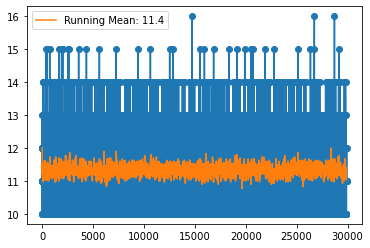

In [13]:
q_table = np.zeros(q_table_shape)
epsilon = 1

####### VISUALIZATION CODE FOR YOU. TOTALLY OPTIONAL. ##########################
########## FEEL FREE TO REMOVE OR ADD YOUR OWN VISUAL CODE. #################

log_interval = 100  # How often do we update the plot? (Just for performance reasons)
### Here we set up the routine for the live plotting of the achieved points ######
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

max_position_log = []  # to store all achieved points
mean_positions_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting


#############################################################################
################################## TRAINING TASKS ##########################
###########################################################################
for epoch in range(EPOCHS):
    ################################# TODO ######################################
    
    # TODO: Get initial observation and discretize them. Set done to False
    #########################################
    initial_observation = env.reset()
    discrete_state = discretize_observation(initial_observation, BINS)
    done = False
    ##########################################
    
    #############################
    # These lines are for plotting.
    max_position = -np.inf  
    epochs.append(epoch)
    #############################
    
    # TASK TO DO: As long as current run is alive (i.e not done) perform the following steps:
    while not done:  # Perform current run as long as done is False (as long as there is still time to reach the top)

        ##########################################
        # TASK TO DO: Select action according to epsilon-greedy strategy
        #########################################
        action = epsilon_greedy_action_selection(epsilon, q_table, discrete_state)

        ##########################################
        # TASK TO DO: Perform selected action and get next state. Do not forget to discretize it
        #########################################
        next_state, reward, done, info = env.step(action)
        discretized_next_state = discretize_observation(next_state, BINS)

        ##########################################
        # TASK TO DO: Get old Q-value from Q-Table and get next optimal Q-Value
        #########################################
        old_q_value = q_table[discrete_state + (action,)]
        next_optimal_q_value = np.argmax(q_table[discretized_next_state + (action,)])

        ##########################################
        # TASK TO DO: Compute next Q-Value and insert it into the table
        #########################################
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        q_table[discrete_state + (action,)] = next_q

        ##########################################
        # TASK TO DO: Update the old state with the new one
        #########################################
        discrete_state = discretized_next_state

        ##########################################
        
        
        ##############################
        ##  Only for plotting the results - store the highest point the car is able to reach
        position = discretized_next_state[0]  #next_state[0]
        if position > max_position:  
            max_position = position

    # TASK TO DO: Reduce epsilon
    #########################################
    epsilon = reduce_epsilon(epsilon, epoch)
    ##########################################
    ##############################################################################

    max_position_log.append(max_position)  # log the highest position the car was able to reach
    running_mean = round(np.mean(max_position_log[-30:]), 2)  # Compute running mean of position over the last 30 epochs
    mean_positions_log.append(running_mean)  # and log it
    
    ################ Plot the points and running mean ##################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, max_position_log)
        ax.plot(epochs, max_position_log)
        ax.plot(epochs, mean_positions_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
  ######################################################################

env.close()


**(numpy) what means array[i + (j,)]**

In [14]:
arr = np.arange(1, 10).reshape(3, 3)
arr

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [15]:
arr[0]

array([1, 2, 3])

In [16]:
arr[0][0]

1

In [17]:
arr[0,0]

1

In [18]:
arr[(0,) + (0,)]

1

=> with 'q_table[discrete_state + (action,)]' we adding the action to the state, so we have all indexes to get to a value

**TASK: Use your Q-Table to test your agent and render its performance.**

In [19]:
env = gym.make('MountainCar-v0')
observation = env.reset()

for step in range(10000):
    env.render()
    # get the action with max q_value
    discretized_observation = discretize_observation(observation, BINS)
    action = np.argmax(q_table[discretized_observation])
    # make turn
    observation, reward, done, info = env.step(action)

    if done:
        print(f"It's done! Reward = {reward}")
        break

    time.sleep(0.03)

c:\Users\tobia\.conda\envs\ai\lib\site-packages\gym\core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


It's done! Reward = -1.0


**OPTIONAL: Play with our Q-Table with 40 bins per observation.**

In [20]:
# We saved our matrix q_table for you (with 40 bins)

In [21]:
our_q_table = np.load('40bin_qtable_mountaincar.npy')

FileNotFoundError: [Errno 2] No such file or directory: '40bin_qtable_mountaincar.npy'

In [ ]:
our_q_table.shape

(40, 40, 3)

**Great job! Note how you could train for many more epochs/episodes or edit hyperparameters, the more complex the environment, the more choices you have to experiment with!**